In [1]:
### if we increase gamma, execution time is larger, but most optimal solution, current = 0.5 when 10x10, obs = 1, player = 1, player+obs mode = random, epoch = 100
### high alpha is better in this scenario, current = 0.8 when 10x10, obs = 1, player = 1, player+obs mode = random, epoch = 100
### low epsilon is better, current = 0.08 when 10x10, obs = 1, player = 1, player+obs mode = random, epoch = 100

from Environment.environment_BRNETp import Env
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import pickle
import uuid
import time
import math
import os
import copy
import rdp_accountant
from rdp_accountant import compute_rdp
from rdp_accountant import get_privacy_spent
from operator import add, sub, mul

## starting main program
start = time.time()

# gridWidthList = [5]
# gridHeightList = [5]
# noAgentList = [3]
# noObsList = [3]
# eList = [1000]
# LoopVal = 1
# neighborWeightsList = [0.85]
# playModeList = ['random'] 

gridWidthList = [30]
gridHeightList = [30]
noAgentList = [20]
noObsList = [5]
eList = [2000]
LoopVal = 1
neighborWeightsList = [0.85]
playModeList = ['random'] 
flag = 0

noTarget = 1
noFreeway = 1

#  # reward and penalties
# actionReward = 0
# obsReward = -0.5
# freewayReward = 0.5
# emptycellReward = 0
# hitwallReward = -0.5
# goalReward = 5

 # reward and penalties
actionReward = 0
obsReward = -1.5
freewayReward = 0.5
emptycellReward = 0
hitwallReward = -0.5
goalReward = 10


alpha = 0.1 # RL learning rate
delta = 0.0001
varepsilon = 1
maxDev = (goalReward+freewayReward+emptycellReward)-(obsReward)
sensitivity = alpha*maxDev
mu = 0
c = np.sqrt(2*np.log(1.25/delta))
sigma = ((c*sensitivity)/varepsilon)+0.12
mean = maxDev/2
low = obsReward
upp = goalReward+freewayReward+emptycellReward

diffAvg1 = []
diffAvg2 = []
diffAvg3 = []
diffAvg4 = []
diffAvg5 = []

# Attacker = random.sample(range(0,noAgentList[0]), math.ceil(noAgentList[0]*30/100)) 
# AttackerList = [random.sample(range(0,noAgentList[0]), math.ceil(noAgentList[0]*30/100))] 
# print(AttackerList)
# AttackerList = [[1]]
AttackerList = [[]]
# AttackerList = [[],[1],[2],
#                 [],[2],[1,4]]

orders = ([1.25, 1.5, 1.75, 2., 2.25, 2.5, 3., 3.5, 4., 4.5] + list(range(5, 64)) + [128, 256, 512])


# if (self.p_budget < delta_spent):
#     break
                  
                  
# def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def swap(a):
    max_index=a.index(max(a))
    min_index=a.index(min(a))
    ma=max(a)
    mi=min(a)
    a[max_index]=mi
    a[min_index]=ma
    return a

for CriteriaVal in range(len(gridWidthList)):
    print("##################### Criteria Value: "+str(CriteriaVal)+" #######################\n")
    Attacker = AttackerList[CriteriaVal]
#     Behb_tot = [(noAgentList[CriteriaVal]-1)*100 for i in range(noAgentList[CriteriaVal])]
    Behb_tot = [100000 for i in range(noAgentList[CriteriaVal])]
    Besb_tot = [10000 for i in range(noAgentList[CriteriaVal])]
    fileName = str(uuid.uuid4())[:5]
    stepsListFinal = []
    rewards_all_episodesFinal = []
    qtableListFinal = []
    diffAvg5 = []
    for countVal in range(LoopVal):
        gridWidth = gridWidthList[CriteriaVal]#10
        gridHeight = gridHeightList[CriteriaVal]#10
        playMode = {'Agent':'random', 
                    'Target': 'static', 
                    'Obstacle': playModeList[CriteriaVal],
                    'Freeway': 'static'}
        noAgent = noAgentList[CriteriaVal]
        noObs = noObsList[CriteriaVal]
        neighborWeights = neighborWeightsList[CriteriaVal]

        ## initialize varaibles
        qtableList = []
        aPosList = []
        stateList = []
        rewardList = []
        doneList = []
        actionList = []
        nextStateList = []
        rewards_all_episodes = []
        visitCount = []

        ## Check if no of elements greater than the state space or not
        if (noAgent+noTarget+noObs+noFreeway)>= (gridHeight * gridWidth):
            print("Total number of elements (agents, targets, obstacles) exceeds grid position")
        else:
            # building environment
            env = Env(gridHeight, gridWidth, playMode, noTarget, noAgent, noObs, noFreeway)
            print('-------Initial Environment---------\n')
            env.render()
            print("\n")

        ## for each agent, initializing a Q-table with random Q-values
        for a in range(noAgent):
            qtableList.append(np.random.rand(env.stateCount, env.actionCount).tolist())

        ## hyperparameters
        epochs = eList[CriteriaVal]
        gamma = 0.8 # discount factor
        epsilon = 0.08 #0.08 #exploration-exploitation
        intEpsilon = epsilon
        decay = 0.1
        stepsList = []
        alpha = 0.1 #learning rate
        # gamma = 0.99 # discount factor

        ## display function starts----------------------------------------------
        def dispEnv(stateList, aPosList, noAgent, gridWidth, gridHeight, env, disp, flag):
            if disp == True:
                print('State of the Players: ', stateList, '\n' )
                print('\n Players Info: ---->')
                for a in range(noAgent):
                    print('Position Of Player '+str(a)+': ', aPosList[a])
                print('\n')

            neighborDict = env.neighbors(noAgent, aPosList, gridWidth, gridHeight, flag)  
            neighborPosList = []
            for a in range(noAgent):
                neighborsPrint = []
                indNeighbor = []
                for player in neighborDict[a]:
                    neighborsPrint.append("P"+str(aPosList.index(player)))
                    indNeighbor.append(aPosList.index(player))
                if disp == True:
                    print("Neighbor of P"+ str(a)+" :" + str(neighborsPrint))
                neighborPosList.append(indNeighbor)
                indNeighbor = []
            if disp == True:
                print('\n')
            return neighborPosList
        ## display function ends----------------------------------------------
        
        ## initialize visit count
        for i in range(noAgent):
            visitCount.append([0 for x in range((gridWidth*gridHeight))])
            
        ## initialize experience harvesting budget (EHB) and experience sharing budget (ESB)
        Behb = Behb_tot.copy()
        Besb = Besb_tot.copy()
          
            
            
        ## training loop
        for i in range(epochs):
            print("epoch #", i+1, "/", epochs)
            tPosList, aPosList, stateList, rewardList, doneList, oPosList, fPosList, courierNumber = env.reset(playMode, noTarget, noAgent, noObs,
                                                                       noFreeway, gridWidth, gridHeight, i, CriteriaVal,countVal)
            rewards_current_episode =[0 for a in range(noAgent)]
            doneList = [[a,'False'] for a in range(noAgent)]

            steps = 0
            completedAgent = []
            
#             if i>0:
#                 rdp = compute_rdp(float(3/25), sigma, i, orders)
#                 _,delta_spent, opt_order = get_privacy_spent(orders, rdp, target_eps=varepsilon)
#                 print('Delta spent: ', delta_spent)
#                 print('Delta budget: ', delta)
#                 if (delta < delta_spent):
#                     print("done")
            
            
            
#             while [0, 'True'] not in doneList: # ends when agent0 reaches goal
            while any('False' in sl for sl in doneList): # ends when all agents reach goal
#             while not any('True' in sl for sl in doneList): # ends when any agent reaches goal
                os.system('clear')
                actionList = []
                if steps>(gridWidth*100):
                    break
                else:
                    steps +=1
                    
                
                
                ## find out neighbors starts---------------------------------------------------
                neighborDict = env.neighbors(noAgent, aPosList, gridWidth, gridHeight, flag)  
                neighborPosList = []
                for a in range(noAgent):
                    neighborsPrint = []
                    indNeighbor = []
                    for player in neighborDict[a]:
                        if a != aPosList.index(player):
                            indNeighbor.append(aPosList.index(player))
                        uniqueIndNeighbor = [*set(indNeighbor)]
                    neighborPosList.append(uniqueIndNeighbor)
                    uniqueIndNeighbor = []

                ## find out neighbors ends---------------------------------------------------
                
                ## find which agents have completed
                completedAgent = [i for i, x in enumerate(doneList) if x[1]=='True']
                
                ## update visit count for this state and every agent
                for a in range(noAgent):
                    visitCount[a][stateList[a]] += 1
                
                
                for a in range(noAgent):
                    ## calculate Pehc (experience harvesting confidence) based on visit count and budget
#                     if ((visitCount[a][stateList[a]]< 1) or (visitCount[a][stateList[a]]> 10)):
                    if (visitCount[a][stateList[a]]> 100000):
                        Pehc = 0
                    else:
                        Pehc = (1/np.sqrt(visitCount[a][stateList[a]])) * (np.sqrt(Behb[a]/Behb_tot[a]))
                    
                    if Pehc < 0.1:
#                         print(Pehc,steps, "asking advice")
                        Behb[a] = Behb[a]-1
                        QNeighbor  = []
                        if a not in completedAgent:
                            neighborsOldQ = 0
                            neighborsOldQList = []
                            selfOldQ = qtableList[a][stateList[a]]
                            if neighborPosList[a] !=[]:  #if not empty list
#                                 print("agent: ",a, " | neighbors pos: ",neighborPosList[a])
                                for n in neighborPosList[a]:
                                    ## calculate Pesc (experience sharing confidence) based on visit count and budget
                                    if (visitCount[n][stateList[a]]< visitCount[a][stateList[a]]):
                                        Pesc = 0
                                    else:
                                        Pesc = (1-(1/np.sqrt(visitCount[n][stateList[a]]))) * (np.sqrt(Besb[n]/Besb_tot[n]))
                                    if Pesc > 0:
#                                         print("giving advice by agent: ", n)
                                        Besb[n] = Besb[n]-1
                                        noise = []
                                        for i in range(4): # 04 for a 04 noise output for 04 actions respectively
                                            sd = sigma
                                            X = get_truncated_normal(mean=mean, sd=sd, low=low, upp=upp)
                                            sampledNoise = X.rvs(1).tolist()
                                            noise.append(sampledNoise[0])

                                        neighborsOldQ = [sum(x) for x in zip(qtableList[n][stateList[a]], noise)]
#                                         print("honest neighbor",neighborsOldQ)
                                        
                                        #### Attacking
                                        if n in Attacker:
                                            oldQAttacker = neighborsOldQ.copy()
                                            random.shuffle(neighborsOldQ)
                                            if oldQAttacker != neighborsOldQ:
                                                neighborsOldQ = swap(neighborsOldQ)
                                                ops = (add, sub)
                                                op = random.choice(ops)
                                                if op == add:
                                                    neighborsOldQ = [i+(goalReward/2) for i in neighborsOldQ]
                                                else:
                                                    neighborsOldQ = [i-(goalReward/2) for i in neighborsOldQ]
                                            else:
                                                neighborsOldQ = swap(neighborsOldQ)
                                                ops = (add, sub)
                                                op = random.choice(ops)
                                                if op == add:
                                                    neighborsOldQ = [i+(goalReward/2) for i in neighborsOldQ]
                                                else:
                                                    neighborsOldQ = [i-(goalReward/2) for i in neighborsOldQ]
#                                             print("Attacking by agent: ", n)
#                                             print("After attack neighbor",neighborsOldQ)
                                        else:
                                            neighborsOldQ = neighborsOldQ
                                        neighborsOldQList.append(neighborsOldQ)
                                    else:
                                        neighborsOldQ = []
                                        neighborsOldQList.append(neighborsOldQ)
                                

#                                 print("agent: ",a, " | neighbors Q: ", neighborsOldQList)
                                if any(neighborsOldQList):
                                    for i in range(4):
                                        elem = [item[i] for item in neighborsOldQList if item!=[]]
                                        if abs(max(elem))>abs(min(elem)):
                                            QNeighbor.append(max(elem))
                                        else:
                                            QNeighbor.append(min(elem))
#                                     qtableList[a][stateList[a]] = QNeighbor
                                    qtableList[a][stateList[a]] = [sum(x) for x in zip([i * neighborWeights for i in selfOldQ], 
                                                     [i * (1-neighborWeights) for i in QNeighbor])]
                                else:
                                    qtableList[a][stateList[a]] = selfOldQ
                          
                
                # 1. select action
                if np.random.uniform() < epsilon:
                    for a in range(noAgent):
                        actionList.append(env.randomAction())
                else:
                    for a in range(noAgent):
                        actionList.append(qtableList[a][stateList[a]].index(max(qtableList[a][stateList[a]])))
                   
                soq = copy.deepcopy(qtableList[0])
                
                # 2. take action and observe next state & reward
                nextStateList, rewardList, doneList, oPosList, courierNumber = env.step(actionList, doneList, noTarget, noAgent, noObs, noFreeway,
                                                               actionReward, obsReward, freewayReward, emptycellReward,
                                                               hitwallReward, completedAgent, goalReward)

                # 3. Calculate Q-value
                for a in range(noAgent):
                    if a not in completedAgent:
                        qtableList[a][stateList[a]][actionList[a]] = ((qtableList[a][stateList[a]][actionList[a]] * (1 - alpha)) + (alpha * (rewardList[a] + gamma * max(qtableList[a][nextStateList[a]]))))
                        rewards_current_episode[a] += rewardList[a]
                        stateList[a] = nextStateList[a]
                    else:
                        qtableList[a][stateList[a]][actionList[a]] = qtableList[a][stateList[a]][actionList[a]]
                        rewards_current_episode[a] += rewardList[a]
                        stateList[a] = nextStateList[a]
                

                
                snq = copy.deepcopy(qtableList[0])

                for p in range(len(soq)):
                    for q in range(len(soq[p])):
                        diff = abs(soq[p][q] - snq[p][q])
                        diffAvg1.append(diff)
                    diffAvg2.append(max(diffAvg1))
                    diffAvg1 = []
                diffAvg3.append(max(diffAvg2))
                diffAvg2 = []
   
            diffAvg4.append(max(diffAvg3))
            diffAvg3 = []
            epsilon -= decay*epsilon
            stepsList.append(steps)
            
            rewards_all_episodes.append(rewards_current_episode)
            print("\nDone in", steps, "steps".format(steps))
            print("Reward: ", rewards_current_episode)

        stepsListFinal.append(stepsList)
        stepsList = []
        rewards_all_episodesFinal.append(rewards_all_episodes)
        rewards_all_episodes = []
        qtableListFinal.append(qtableList)
        qtableList = []
        diffAvg5.append(diffAvg4)
        diffAvg4 = []
    
    
    end = time.time()
    total_time = end-start
    print("Total Time: ",total_time) 
    
    s = stepsListFinal
    with open("./BRNETp_out/"+str(fileName)+"_BRNETp_Step", "wb") as Sp:   #Pickling
        pickle.dump(s, Sp)

    r = rewards_all_episodesFinal
    with open("./BRNETp_out/"+str(fileName)+"_BRNETp_Reward", "wb") as Rp:   #Pickling
        pickle.dump(r, Rp)

    q = qtableListFinal
    with open("./BRNETp_out/"+str(fileName)+"_BRNETp_Qtable", "wb") as Qp:   #Pickling
        pickle.dump(q, Qp)
        
    c = diffAvg5
    with open("./BRNETp_out/"+str(fileName)+"_BRNETp_convergence", "wb") as Cp:   #Pickling
        pickle.dump(c, Cp)
    

    t = total_time
    with open("./BRNETp_out/"+str(fileName)+"_BRNETp_Time", "wb") as Tp:   #Pickling
        pickle.dump(t, Tp)   


    with open("./BRNETp_out/fProp2.txt", "a") as myfile:
        myfile.write("FileName: "+str(fileName)+" : BRNETp, Time taken: "+str(total_time)+"\n | gridWidth: "+str(gridWidth)+" | gridHeight: "+str(gridHeight)+
                    " | playMode: "+str(playMode)+" | noTarget: "+str(noTarget)+" | noAgent: "+str(noAgent)+
                    " | noObs: "+str(noObs)+" | noFreeway: "+str(noFreeway)+
                    " | neighborWeights: "+str(neighborWeights)+" | epochs: "+str(epochs)+" | gamma: "+str(gamma)+
                    " | epsilon: "+str(intEpsilon)+" | decay: "+str(decay)+" | alpha: "+str(alpha)+
                    " | obsReward: "+str(obsReward)+" | freewayReward: "+str(freewayReward)+" | emptycellReward: "+str(emptycellReward)+
                    " | hitwallReward: "+str(hitwallReward)+" | Attacker: "+str(Attacker)+"\n\n\n")   




##################### Criteria Value: 0 #######################

-------Initial Environment---------

 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   P15  .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   P9  .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   P19  .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   P7  .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   P16  .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .  


Done in 3001 steps
Reward:  [-5.5, -15.5, -29.5, -30.5, -32.0, -40.0, -54.0, 8.0, -59.0, -59.0, -59.0, -61.0, -86.5, -106.5, -25.0, -109.5, -110.0, -115.0, -122.0, -122.0]
epoch # 25 / 2000

Done in 3001 steps
Reward:  [-22.5, -24.5, -25.0, -26.5, -51.5, -59.5, -75.0, -6.0, -81.0, -81.0, -89.0, -89.0, -91.5, -117.0, -118.5, -124.0, -128.0, -128.0, -131.0, -131.0]
epoch # 26 / 2000

Done in 3001 steps
Reward:  [-24.0, -0.5, -26.0, -26.0, -49.5, -61.0, -68.0, 7.0, -96.0, -96.0, -96.0, -123.0, -127.0, -166.5, -166.5, -189.5, -219.0, -219.0, -220.0, -225.0]
epoch # 27 / 2000

Done in 3001 steps
Reward:  [-14.0, -14.0, -32.0, -43.0, -61.5, -137.5, -142.0, -4.5, -166.0, -168.0, -168.0, -168.0, -168.0, -192.0, -192.0, -214.0, -225.0, -225.0, -230.5, -231.5]
epoch # 28 / 2000

Done in 3001 steps
Reward:  [-1.5, -1.5, -12.5, -13.5, -55.0, -74.0, -82.5, -82.5, -89.5, -91.0, -92.5, -95.0, -95.5, -110.0, -110.0, -123.5, -126.0, -126.0, -127.0, -127.0]
epoch # 29 / 2000

Done in 3001 steps
Reward:

<ipython-input-1-cb712163656d>:265: RuntimeWarning: invalid value encountered in sqrt
  Pehc = (1/np.sqrt(visitCount[a][stateList[a]])) * (np.sqrt(Behb[a]/Behb_tot[a]))



Done in 3001 steps
Reward:  [-10.0, 9.5, 4.5, 5.5, -18.5, -26.0, -33.5, -44.0, 6.5, -47.5, -16.0, -53.5, -58.5, -62.5, -64.5, -75.0, -80.5, -87.5, -92.0, -99.0]
epoch # 41 / 2000

Done in 3001 steps
Reward:  [10, 5.0, 9.0, 9.5, -5.5, -14.0, -16.0, -22.5, 9.0, -25.5, -30.0, 3.5, -31.0, -7.5, -27.0, -45.0, -9.0, -52.0, -55.5, -64.5]
epoch # 42 / 2000

Done in 3001 steps
Reward:  [10, 9.0, 9.5, -22.0, -27.0, -32.5, -33.5, 7.0, 9.0, -40.0, -42.0, -52.5, 6.0, 6.0, -56.5, -63.5, -19.5, -81.0, -92.5, -104.0]
epoch # 43 / 2000

Done in 3001 steps
Reward:  [10, -3.0, 6.5, 9.5, -9.5, -14.5, -20.0, 8.0, 10, -24.5, -33.0, -37.0, -41.0, -3.0, 9.0, -49.5, -31.5, -54.5, -66.0, -58.5]
epoch # 44 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.0, 8.0, 6.0, -7.0, -21.5, 7.0, 9.0, -29.5, -34.5, -25.0, 9.0, -41.5, -46.5, -56.5, -0.5, -58.5, -66.0, -72.0]
epoch # 45 / 2000

Done in 3001 steps
Reward:  [-5.0, 5.0, 8.5, 8.5, -9.0, -13.5, -26.5, -42.0, 7.0, -43.0, -6.0, -34.5, -29.0, -29.5, 2.0, -71.5, -1.5, 


Done in 3001 steps
Reward:  [10, 9.5, 9.5, 9.0, 9.0, -4.5, 6.0, 9.5, 6.5, 6.5, 8.0, 7.0, 8.0, 8.5, 2.5, -1.0, 2.0, -14.5, -0.5, 7.0]
epoch # 91 / 2000

Done in 3001 steps
Reward:  [10, 8.0, 7.0, 9.0, 8.0, 8.5, 7.0, 9.5, 7.0, 4.5, 8.5, 6.5, 3.0, 1.0, 0.0, 3.0, -17.5, -17.5, -1.5, 1.5]
epoch # 92 / 2000

Done in 3001 steps
Reward:  [9.0, 8.0, 10, 8.0, 8.0, 6.0, 5.0, 10, 5.0, 0.0, -1.0, 7.0, -2.5, 8.5, -2.5, 3.5, -16.5, -18.0, -7.5, 7.0]
epoch # 93 / 2000

Done in 3001 steps
Reward:  [8.5, 10, 10, 7.0, 1.0, -10.5, 10, -1.5, -3.5, -4.0, 10, 9.5, -2.5, 9.5, -1.5, 6.0, 5.5, -9.0, -1.0, 1.5]
epoch # 94 / 2000

Done in 3001 steps
Reward:  [9.5, 8.5, 8.5, 8.5, 7.0, 7.5, 6.5, -9.5, 8.5, 5.0, 2.5, 7.0, 0.5, 5.0, -5.0, -3.5, -8.0, -4.0, 2.0, 6.5]
epoch # 95 / 2000

Done in 3001 steps
Reward:  [8.0, 9.5, 9.5, 9.5, 2.5, 7.0, 1.0, 8.0, 8.0, -12.0, 8.5, -4.5, -6.5, 1.5, -7.5, -9.0, -2.5, -10.5, -6.5, 7.0]
epoch # 96 / 2000

Done in 3001 steps
Reward:  [9.0, 10, 9.5, 4.5, 8.0, -8.5, 4.0, 8.5, -5.0, 6.


Done in 3001 steps
Reward:  [9.0, 10, 7.0, 5.0, 6.5, 4.5, 8.5, 10, 8.0, 10, 8.0, -1.0, 1.5, 7.5, -6.5, -2.5, -20.0, 7.5, -8.0, 5.0]
epoch # 145 / 2000

Done in 3001 steps
Reward:  [9.0, 10, 9.5, 8.0, 9.0, 9.0, 9.0, 10, 9.5, 9.5, 8.5, 8.0, 8.5, 8.0, 8.0, 7.5, -4.5, 8.5, 7.0, 7.0]
epoch # 146 / 2000

Done in 2568 steps
Reward:  [7.0, 10, 10, 8.0, 9.0, 8.5, 10, 10, 10, 10, 8.0, 7.0, 7.5, 8.5, 4.5, 7.0, 3.5, 3.0, 9.0, 9.0]
epoch # 147 / 2000

Done in 2655 steps
Reward:  [10, 10, 10, 5.5, 7.5, 9.5, 8.5, 10, 9.5, 9.5, 7.0, 7.5, 3.0, 5.0, 4.0, 8.0, 0.5, 8.0, 8.0, 6.5]
epoch # 148 / 2000

Done in 2838 steps
Reward:  [9.5, 10, 10, 8.5, 9.5, 10, 10, 10, 9.5, 10, 9.0, 7.0, 10, 10, 7.5, 5.0, 8.5, 8.5, 9.5, 2.0]
epoch # 149 / 2000

Done in 3001 steps
Reward:  [9.5, 10, 7.0, 7.5, 9.0, 6.0, 9.5, 10, 9.0, 10, 7.0, 8.0, 8.5, 7.5, 7.0, 6.5, -7.0, 8.5, 7.5, 6.0]
epoch # 150 / 2000

Done in 1595 steps
Reward:  [10, 10, 10, 7.5, 10, 10, 10, 10, 10, 10, 10, 6.5, 7.5, 7.0, 4.5, 3.5, 4.0, 8.5, 8.5, 5.0]
epoc


Done in 3001 steps
Reward:  [8.5, 4.0, 9.5, 9.5, 10, 8.5, 8.0, 9.0, 8.5, 2.5, 7.0, 7.5, 10, 1.5, 6.5, -12.0, 3.0, 3.0, 7.5, 10]
epoch # 201 / 2000

Done in 2931 steps
Reward:  [9.0, 8.5, 8.5, 9.5, 9.5, 9.0, 8.5, 6.5, 8.0, 9.5, 8.0, 7.5, 7.5, 9.5, 4.0, 8.0, 8.0, 3.5, 8.5, 7.5]
epoch # 202 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 10, 10, 10, 9.5, 9.5, 10, 10, 10, 10, 9.5, 10, 9.0, -2.5, 8.5, 8.0, 10, 8.5]
epoch # 203 / 2000

Done in 1247 steps
Reward:  [10, 9.0, 6.5, 10, 9.5, 9.5, 6.5, 9.5, 9.5, 10, 10, 8.5, 9.0, 9.5, 8.5, 9.5, 9.5, 8.0, 9.5, 9.0]
epoch # 204 / 2000

Done in 1445 steps
Reward:  [9.0, 9.0, 7.5, 10, 9.0, 10, 6.0, 3.5, 4.0, 10, 10, 7.0, 7.0, 5.5, 3.5, 1.0, 9.5, 5.5, 7.0, 5.5]
epoch # 205 / 2000

Done in 1077 steps
Reward:  [9.0, 9.0, 9.0, 10, 9.5, 8.5, 8.5, 8.5, 8.5, 10, 7.0, 8.0, 4.5, 9.0, 5.5, 4.0, 9.0, 3.5, 5.5, 4.5]
epoch # 206 / 2000

Done in 3001 steps
Reward:  [10, 9.0, 9.0, 9.5, 9.5, 9.0, 8.5, 7.0, 8.0, 10, 9.5, 8.5, 8.5, 7.0, 7.5, 8.5, 8.5, -4.0, 8.5, 7.5


Done in 1027 steps
Reward:  [9.5, 10, 10, 9.5, 10, 9.0, 10, 10, 10, 9.0, 10, 9.0, 10, 9.0, 9.0, 10, 10, 10, 10, 8.0]
epoch # 259 / 2000

Done in 1372 steps
Reward:  [8.0, 10, 10, 7.0, 9.0, 7.5, 9.0, 6.0, 6.5, 5.5, 8.0, 7.0, 7.5, 5.0, 6.5, 10, 10, 10, 6.5, 8.0]
epoch # 260 / 2000

Done in 1980 steps
Reward:  [10, 10, 10, 10, 10, 10, 8.5, 9.5, 9.0, 6.0, 10, 9.0, 6.5, 10, 8.5, 10, 10, 10, 10, 8.0]
epoch # 261 / 2000

Done in 1384 steps
Reward:  [9.5, 9.0, 9.5, 9.0, 10, 9.5, 9.5, 9.5, 8.5, 10, 10, 10, 9.5, 8.5, 10, 10, 8.5, 10, 8.5, 10]
epoch # 262 / 2000

Done in 2334 steps
Reward:  [10, 9.0, 10, 10, 10, 9.5, 10, 7.5, 6.0, 10, 9.5, 9.5, 7.0, 5.5, 10, 10, 5.0, 10, 9.5, 8.5]
epoch # 263 / 2000

Done in 2102 steps
Reward:  [10, 9.5, 8.5, 9.5, 10, 9.5, 9.5, 9.0, 9.0, 10, 8.5, 10, 8.0, 7.5, 9.5, 9.5, 6.0, 10, 8.0, 5.5]
epoch # 264 / 2000

Done in 936 steps
Reward:  [9.5, 9.5, 9.5, 9.5, 10, 9.5, 8.0, 9.0, 7.5, 10, 9.5, 9.5, 8.0, 7.5, 10, 8.5, 7.0, 10, 9.5, 8.5]
epoch # 265 / 2000

Done in 1536


Done in 737 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 9.0, 9.0, 9.0, 8.5, 9.5, 9.0, 8.5, 10, 10, 8.5, 8.5, 10]
epoch # 317 / 2000

Done in 891 steps
Reward:  [9.0, 9.5, 8.5, 9.0, 9.0, 9.0, 9.5, 7.5, 7.5, 8.0, 8.0, 7.5, 7.5, 7.5, 6.0, 10, 10, 10, 10, 10]
epoch # 318 / 2000

Done in 1219 steps
Reward:  [10, 10, 10, 10, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 8.5, 8.5, 9.0, 8.5, 10, 10, 9.5, 9.5, 10]
epoch # 319 / 2000

Done in 982 steps
Reward:  [10, 8.0, 10, 9.5, 9.5, 9.5, 10, 9.0, 9.5, 9.5, 9.0, 9.0, 9.5, 9.0, 9.0, 10, 10, 9.0, 9.5, 10]
epoch # 320 / 2000

Done in 1105 steps
Reward:  [10, 9.5, 10, 9.5, 9.5, 9.5, 10, 9.5, 9.0, 8.5, 9.5, 9.0, 8.0, 9.5, 7.0, 10, 10, 8.5, 9.5, 10]
epoch # 321 / 2000

Done in 711 steps
Reward:  [10, 10, 10, 9.5, 10, 10, 9.5, 10, 10, 9.0, 10, 9.0, 9.0, 8.5, 8.5, 10, 9.0, 9.0, 9.0, 9.0]
epoch # 322 / 2000

Done in 3001 steps
Reward:  [9.5, 10, 10, 10, 10, 10, 9.0, 9.5, 10, 8.5, 10, 8.5, 9.0, 9.0, 7.5, 10, -3.0, 8.5, 10, 6.5]
epoch # 323 / 2000

Done in 3001 


Done in 3001 steps
Reward:  [10, 9.0, 9.5, 9.0, 7.5, 9.0, 10, 9.5, 10, 10, 9.0, 7.5, 8.5, 7.0, 8.0, -3.5, 7.5, 10, 10, 10]
epoch # 376 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 9.0, 9.0, 9.0, 9.0, 9.0, 10, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, -1.0, 10, 10, 9.0]
epoch # 377 / 2000

Done in 3001 steps
Reward:  [10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 10, 9.5, 9.5, 8.5, 9.0, 9.0, 9.0, -2.0, 8.5, 10, 10, 8.5]
epoch # 378 / 2000

Done in 550 steps
Reward:  [10, 9.5, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10, 10, 9.0, 9.0, 9.0, 8.0, 9.0, 8.0, 9.0, 10, 10, 10]
epoch # 379 / 2000

Done in 3001 steps
Reward:  [9.5, 9.5, 10, 10, 8.5, 8.5, 9.0, 8.5, 10, 10, 8.5, 9.5, 8.0, 8.0, 8.0, -2.0, 10, 10, 10, 9.5]
epoch # 380 / 2000

Done in 940 steps
Reward:  [10, 9.5, 10, 9.5, 9.5, 10, 10, 10, 10, 10, 10, 9.5, 10, 10, 10, 10, 9.5, 10, 10, 10]
epoch # 381 / 2000

Done in 1470 steps
Reward:  [9.5, 10, 9.5, 10, 9.0, 10, 9.0, 9.0, 10, 10, 10, 10, 9.0, 9.5, 9.5, 9.5, 9.5, 9.5, 8.0, 9.0]
epoch # 382 / 2000

Done i


Done in 3001 steps
Reward:  [10, 10, 9.5, 9.5, 10, 9.5, 9.5, 9.5, 8.0, 10, 9.0, 10, 10, 7.5, 9.0, -2.5, 9.0, 9.0, 7.5, 10]
epoch # 435 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 10, 10, 10, 10, -0.5, 10, 10, 9.5, 10]
epoch # 436 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 9.5, 10, 10, 9.5, 9.5, 9.5, 10, 9.5, 10, 10, 9.5, 9.0, 9.0, -1.0, 9.0, 9.0, 9.0]
epoch # 437 / 2000

Done in 3001 steps
Reward:  [10, 9.5, 9.5, 9.5, 10, 8.5, 9.5, 8.0, 8.5, 10, 9.5, 9.5, 10, 9.5, 9.0, -2.0, -2.0, 9.5, 8.0, 10]
epoch # 438 / 2000

Done in 1525 steps
Reward:  [10, 10, 9.5, 9.5, 10, 10, 9.5, 9.5, 8.0, 10, 9.5, 10, 10, 9.0, 9.0, 9.5, 8.5, 10, 7.5, 9.5]
epoch # 439 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 9.5, 10, 9.5, 9.5, 9.5, 9.0, 10, 9.0, 9.5, 10, 8.5, 8.5, -1.5, 9.0, -1.5, 9.0, 9.5]
epoch # 440 / 2000

Done in 796 steps
Reward:  [10, 9.5, 9.5, 10, 10, 9.5, 10, 9.5, 9.0, 10, 10, 10, 10, 10, 9.0, 9.0, 10, 10, 9.0, 10]
epoch # 441 / 2000

Done in 811 


Done in 896 steps
Reward:  [10, 10, 10, 10, 9.5, 9.0, 10, 8.5, 8.0, 9.5, 8.0, 9.5, 8.0, 8.0, 7.5, 9.5, 7.5, 9.0, 9.0, 8.5]
epoch # 494 / 2000

Done in 1016 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 9.5, 8.5, 10, 10, 8.0, 9.5, 10, 9.5, 9.0, 10, 8.0]
epoch # 495 / 2000

Done in 545 steps
Reward:  [10, 10, 10, 10, 10, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 10, 9.5, 10, 9.0, 10, 10, 9.0]
epoch # 496 / 2000

Done in 869 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 9.5, 8.5, 8.5, 7.5, 10, 7.5, 10, 8.5, 10, 8.0, 10, 10, 9.5]
epoch # 497 / 2000

Done in 494 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 498 / 2000

Done in 921 steps
Reward:  [10, 10, 9.0, 9.0, 9.5, 8.5, 8.5, 9.5, 10, 9.5, 8.0, 9.0, 8.0, 8.5, 8.5, 10, 9.0, 9.5, 9.5, 6.5]
epoch # 499 / 2000

Done in 1110 steps
Reward:  [10, 10, 8.0, 8.5, 9.5, 8.0, 9.0, 8.0, 7.5, 8.5, 8.5, 9.0, 9.0, 9.0, 7.5, 9.0, 7.5, 7.5, 9.0, 7.5]
epoch # 500 / 2000

Done in 509 steps
Reward:


Done in 1061 steps
Reward:  [10, 10, 10, 9.5, 9.5, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 10, 9.5, 10, 9.5, 9.5, 10, 9.5, 10]
epoch # 553 / 2000

Done in 551 steps
Reward:  [10, 10, 10, 10, 10, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5]
epoch # 554 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 9.5, 9.5, 10, 8.5, 8.0, 8.0, 9.0, 7.5, 7.5, 9.5, 7.0, 10, -3.0, 7.5, 10, 9.0, 9.5]
epoch # 555 / 2000

Done in 830 steps
Reward:  [9.5, 9.5, 9.5, 9.5, 8.5, 9.5, 7.5, 8.0, 9.5, 8.5, 8.0, 9.5, 9.5, 7.0, 9.5, 9.5, 7.5, 10, 9.5, 9.5]
epoch # 556 / 2000

Done in 580 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 557 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, -0.5, 9.5, 10, 9.5, 9.5]
epoch # 558 / 2000

Done in 576 steps
Reward:  [10, 10, 9.0, 10, 8.5, 10, 9.0, 8.0, 8.5, 9.0, 7.5, 8.5, 9.0, 9.0, 10, 10, 8.0, 10, 8.0, 10]
epoch # 559 / 2000

Done in 575 st


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 613 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10]
epoch # 614 / 2000

Done in 426 steps
Reward:  [10, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 10, 9.5, 9.5, 9.0, 10, 10, 8.5, 8.5, 8.5, 8.5, 9.5, 9.5]
epoch # 615 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 9.5, 9.5, 9.5, 9.5, -0.5, 10, 9.5, 9.5, 9.5, 10, 10, 9.5, -0.5, 9.5, 9.5, 9.5, 9.5]
epoch # 616 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 9.5, 10, 10, 10, 9.5, 10, -0.5, 9.0, 10]
epoch # 617 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 618 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 9.5, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 10, 10]
epoch # 619 / 2000

Done in 878 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10,


Done in 371 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 675 / 2000

Done in 3001 steps
Reward:  [9.5, 10, 10, 10, 10, 10, 9.5, 10, 10, 9.5, 9.5, 10, 10, 10, 10, -0.5, -0.5, 10, 10, 10]
epoch # 676 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 677 / 2000

Done in 1069 steps
Reward:  [10, 10, 9.5, 10, 10, 10, 10, 9.5, 10, 9.5, 9.5, 10, 9.0, 9.0, 10, 8.5, 9.0, 10, 10, 8.5]
epoch # 678 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 9.5, 10, 10, 10, 10, 10, 10, 9.0, 10, 9.5, 9.5, 10, 9.5, -1.0, 10, 10, 10]
epoch # 679 / 2000

Done in 3001 steps
Reward:  [9.5, 10, 9.0, 8.5, 10, 10, 10, 8.5, 10, 9.0, 9.0, 10, 8.5, 8.0, 10, 8.5, -2.0, 10, 10, 8.0]
epoch # 680 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 9.5, 10, 10, 10, 9.5, 10, 10, 10, 10, 9.5, 9.5, 10, 9.5, -0.5, 10, 10, 9.5]
epoch # 681 / 2000

Done in 552 steps
Reward:  [10, 9.5, 10, 10, 10, 9.5, 


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 9.5, 10, 9.5, 9.0, 10, 9.0, 10, 9.5, -1.0, 10, 9.5, 9.5, 9.0]
epoch # 736 / 2000

Done in 899 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 9.5, 10, 9.5, 9.0, 9.5, 9.0, 9.5, 9.0, 9.0, 9.5, 9.0, 9.0, 8.5]
epoch # 737 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 738 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 739 / 2000

Done in 400 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 9.5]
epoch # 740 / 2000

Done in 552 steps
Reward:  [10, 10, 10, 9.5, 10, 10, 9.5, 9.5, 10, 9.5, 9.5, 10, 9.5, 10, 9.5, 10, 10, 10, 10, 9.5]
epoch # 741 / 2000

Done in 633 steps
Reward:  [10, 10, 9.5, 10, 9.5, 10, 8.5, 10, 10, 10, 9.0, 8.0, 9.0, 8.5, 9.5, 7.5, 9.5, 10, 9.5, 8.5]
epoch # 742 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 


Done in 498 steps
Reward:  [10, 9.5, 10, 9.5, 9.5, 9.5, 10, 9.5, 10, 10, 10, 10, 10, 9.0, 10, 9.0, 10, 9.0, 10, 9.0]
epoch # 797 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10]
epoch # 798 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 799 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10]
epoch # 800 / 2000

Done in 841 steps
Reward:  [10, 10, 10, 10, 10, 8.0, 10, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 801 / 2000

Done in 509 steps
Reward:  [10, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9.5]
epoch # 802 / 2000

Done in 756 steps
Reward:  [10, 10, 10, 10, 9.5, 9.5, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 803 / 2000

Done in 3001 steps
Reward:  [10, 9.5, 9.5, 10, 9.5, 9.5, 9.5, 10, 10, 9.5, 9.5, 10, 9.5


Done in 575 steps
Reward:  [10, 10, 10, 10, 10, 9.5, 9.5, 10, 10, 9.5, 9.0, 10, 10, 9.5, 9.0, 9.5, 10, 10, 10, 9.5]
epoch # 859 / 2000

Done in 555 steps
Reward:  [10, 10, 10, 9.5, 9.5, 9.5, 9.5, 10, 10, 9.5, 9.5, 10, 10, 9.0, 9.0, 9.5, 10, 10, 10, 9.5]
epoch # 860 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 861 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 9.5, 10, 10, 9.0, 10, 10, 9.0, 9.0, 9.0, 10, 10, 10, 9.0, -1.0, 10, 10, 10]
epoch # 862 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10]
epoch # 863 / 2000

Done in 3001 steps
Reward:  [10, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.5, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, -1.0, -1.0, 9.0, 9.0, 9.0]
epoch # 864 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, -0.5, 9.5, 9.5, 9.5]
epoch # 865 / 2000

Done in 3001 steps
Reward:  [10, 10


Done in 633 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 922 / 2000

Done in 405 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 923 / 2000

Done in 701 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 924 / 2000

Done in 505 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 925 / 2000

Done in 350 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 926 / 2000

Done in 737 steps
Reward:  [9.5, 10, 10, 10, 10, 10, 9.0, 10, 10, 10, 10, 8.5, 10, 10, 10, 10, 10, 9.0, 10, 10]
epoch # 927 / 2000

Done in 500 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 928 / 2000

Done in 433 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,


Done in 3001 steps
Reward:  [9.5, 10, 10, 10, 9.5, 10, 10, 9.5, 9.0, 10, 9.5, 9.5, 9.5, 9.5, 10, -1.0, -1.0, 10, 10, 10]
epoch # 985 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 986 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 9.5, 10, 10, 10, 10, 9.5, 9.0, -1.0, 9.5, 9.5, 10, 9.5]
epoch # 987 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, -0.5, -0.5, 10, 10, 10]
epoch # 988 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 10, 9.5, 10, 9.5, 10, -0.5, 10, 10, 10, 10]
epoch # 989 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 990 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 991 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 9.5, 10, 10, 9.5, 9.5, 1


Done in 3001 steps
Reward:  [10, 10, 9.5, 10, 9.5, 10, 10, 10, 9.5, 10, 9.5, 10, 10, 9.5, 10, -0.5, 10, -0.5, 10, 10]
epoch # 1047 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1048 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 10, 0, 10, 10]
epoch # 1049 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 10, 10, -0.5, 10, 10, -0.5, 10, -0.5, 10, 10]
epoch # 1050 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1051 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1052 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1053 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 0, 10, 10, 10]
epoch # 1109 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 0, 0, 10, 10]
epoch # 1110 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 10, 10, 10]
epoch # 1111 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 0, 10, 10]
epoch # 1112 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 10, 10, 10]
epoch # 1113 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 10, 10, 10]
epoch # 1114 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 0, 10, 10]
epoch # 1115 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 10, 10, 10]
epoch


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 10, 10]
epoch # 1172 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 0, 10, 10]
epoch # 1173 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10, 10, 10]
epoch # 1174 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 10, 10]
epoch # 1175 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 10, 10]
epoch # 1176 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 10, 10, 10]
epoch # 1177 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10]
epoch # 1178 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 10, 9.5, 9.5, 10, 10, 10, 9.5, 10, 9.5, 10, 9.5, 9.5, -0.5, -0.5


Done in 3001 steps
Reward:  [10, 10, 9.5, 9.5, 9.0, 9.5, 9.0, 9.5, 9.5, 9.5, 9.0, 9.0, 9.0, 9.5, 9.5, 9.0, -1.0, -1.0, 9.0, 9.5]
epoch # 1235 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10]
epoch # 1236 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 10, 10]
epoch # 1237 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10]
epoch # 1238 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9.5, -0.5, -0.5, 10, 10]
epoch # 1239 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 10, 10]
epoch # 1240 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 10, 10]
epoch # 1241 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, -0.5, -0.5, 9.5, 9.0, 9.0]
epoch # 1297 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10]
epoch # 1298 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, -0.5, 9.5, 9.5, 9.5]
epoch # 1299 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10]
epoch # 1300 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10]
epoch # 1301 / 2000

Done in 318 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 1302 / 2000

Done in 155 steps
Reward:  [10, 10, 10, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 1303 / 2000

Done in 260 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1


Done in 3001 steps
Reward:  [10, 10, 9.5, 9.5, 9.5, 9.5, 10, 10, 9.5, 9.5, 9.5, 9.5, -0.5, 9.5, 9.5, -0.5, -0.5, 9.5, 9.5, 9.5]
epoch # 1358 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 10, 10]
epoch # 1359 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 10, 10, 10]
epoch # 1360 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 9.5, -0.5, -1.0, 10, 9.0, 9.0]
epoch # 1361 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 1362 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 1363 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -0.5, 10, 10, 10, 10]
epoch # 1364 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1


Done in 3001 steps
Reward:  [10, 9.5, 10, 9.5, 10, 9.5, 10, 10, 10, 9.0, 9.0, 10, 10, 9.0, 10, 10, 10, -1.0, 10, 10]
epoch # 1421 / 2000

Done in 279 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 1422 / 2000

Done in 184 steps
Reward:  [10, 10, 10, 9.5, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5]
epoch # 1423 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10]
epoch # 1424 / 2000

Done in 264 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 1425 / 2000

Done in 205 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 1426 / 2000

Done in 322 steps
Reward:  [9.5, 9.5, 9.5, 9.5, 10, 10, 10, 10, 9.5, 10, 9.5, 10, 9.5, 9.5, 9.5, 10, 9.5, 10, 10, 10]
epoch # 1427 / 2000

Done in 400 steps
Reward:  [10, 10, 10, 9.5, 10, 10, 10, 10, 


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 1484 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 10, 10, 10, 9.5, 10, -0.5, 10, 10, 10, 10]
epoch # 1485 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 1486 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9.5, 10, 10, 9.5, 10, -0.5, 10, -0.5, 9.0, 10]
epoch # 1487 / 2000

Done in 3001 steps
Reward:  [9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, -0.5, 9.5, 9.5, 9.5, 10]
epoch # 1488 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 0, 10, 10]
epoch # 1489 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 9.5, 10]
epoch # 1490 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10


Done in 3001 steps
Reward:  [10, 10, 10, 9.5, 9.5, 10, 9.5, 10, 10, 10, 10, 9.5, -0.5, 10, 9.5, -0.5, -0.5, 9.5, 9.5, 10]
epoch # 1547 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10]
epoch # 1548 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 10, 0, 10]
epoch # 1549 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 1550 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 10, 10]
epoch # 1551 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10]
epoch # 1552 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 1553 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 10, 9.5, 


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 0, 10, 10, 0, 10, 10, 10, 10]
epoch # 1610 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 0, 10, 0, 0, 10, 10, 10, 10]
epoch # 1611 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 10, 10, 10, 10]
epoch # 1612 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 10, 10, 10, 10]
epoch # 1613 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 10, 10, 10, 10]
epoch # 1614 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 10, 10, 10, 10]
epoch # 1615 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 0, 10, 0, 0, 10, 10, 10, 10]
epoch # 1616 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 10, 0, 10, 10]
ep


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 10, 10]
epoch # 1674 / 2000

Done in 403 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
epoch # 1675 / 2000

Done in 373 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 9.0, 10, 9.5, 10, 10, 10, 10, 9.0, 10, 10, 9.5, 9.5, 10]
epoch # 1676 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10]
epoch # 1677 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10]
epoch # 1678 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10]
epoch # 1679 / 2000

Done in 3001 steps
Reward:  [9.5, 9.5, 10, 9.5, 10, 9.5, 10, 9.5, 9.0, 9.5, 10, 9.5, 10, -1.0, 9.0, 10, 10, 9.0, 9.5, 9.0]
epoch # 1680 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10,


Done in 3001 steps
Reward:  [10, 10, 10, 10, 9.5, 9.5, 10, 10, 10, 10, 9.5, 10, -0.5, 9.5, 10, -0.5, 9.5, 10, 10, 10]
epoch # 1737 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 0, 10, 10]
epoch # 1738 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 9.5, 10, 10, 10, 10, -0.5, -0.5, 9.5, 10, 10]
epoch # 1739 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 10, 10, 10]
epoch # 1740 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 1741 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 1742 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 1743 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 0, 10]
epoch # 1800 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 0, 10]
epoch # 1801 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 9.5, 10, 10, 9.5, 10, 9.5, 9.5, -0.5, 10, 9.5, 9.5, 9.5]
epoch # 1802 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 1803 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1804 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10]
epoch # 1805 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1806 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 10, 9.5, -0.5, -0.5, 10, 9.5, 9.5]
epoch # 1863 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 10, 10, 10, 9.5, 9.5, 10, 9.5, 10, 9.5, 10, 10, 10, -0.5, -0.5, 10, 9.5, 9.5]
epoch # 1864 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 1865 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 1866 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 9.5, 9.5]
epoch # 1867 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 10, 10, 10, 10, 9.5, 9.5, 10, 10, 10, 10, 10, 10, -0.5, -0.5, 10, -0.5, 9.0]
epoch # 1868 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, -0.5, 9.5, 9.5, 10, 9.5, 9.5, 10, 9.5, -0.5, -0.5, 10, 9.5, 9.5]
epoch # 1869 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 1


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, -0.5, 9.5, 9.5]
epoch # 1926 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1927 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1928 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1929 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1930 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1931 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 10, 10]
epoch # 1932 / 2000

Done in 3001 steps
Reward:  [10, 10, 9.5, 10, 10, 9.5, 9.5, -0.5, 10, 10, 9.5, 10, 10, 9.5,


Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 1990 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 9.5, 9.5, 9.5, 10, 10, 9.5, 9.5, -0.5, -0.5, 10, 9.5, 9.0]
epoch # 1991 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 9.5, 10, 10, 10, 10, 10, 10, -0.5, -0.5, 10, 10, 10]
epoch # 1992 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 10]
epoch # 1993 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 1994 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 10, 10]
epoch # 1995 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 10]
epoch # 1996 / 2000

Done in 3001 steps
Reward:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

In [3]:
fileName

'be7b5'

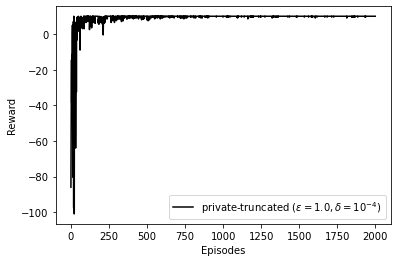

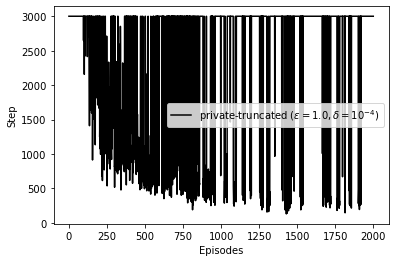

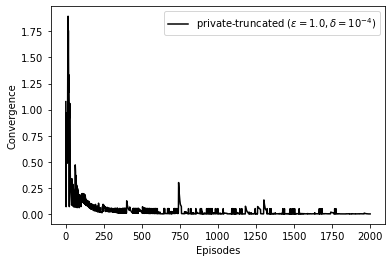

In [2]:
agent1reward = []
for y in range(len(rewards_all_episodesFinal[0])):
    agent1reward.append(rewards_all_episodesFinal[0][y][2])

# withCoOpWithDPReward1 = agent1reward
withCoOpWithDPReward2 = agent1reward
# plt.plot(withCoOpWithDPReward1, '-m', markerfacecolor="none", label="private-truncated ($\epsilon=1.0, \delta = 10^{-4}$)")
plt.plot(withCoOpWithDPReward2, '-k', markerfacecolor="none", label="private-truncated ($\epsilon=1.0, \delta = 10^{-4}$)")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()


# withCoOpWithDPStep1 = stepsListFinal[0]
withCoOpWithDPStep2 = stepsListFinal[0]
# plt.plot(withCoOpWithDPStep1, '-m', markerfacecolor="none", label="private-truncated ($\epsilon=1.0, \delta = 10^{-4}$)")
plt.plot(withCoOpWithDPStep2, '-k', markerfacecolor="none", label="private-truncated ($\epsilon=1.0, \delta = 10^{-4}$)")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Step")
plt.show()

# withCoOpWithDPConv1 = diffAvg5[0]
withCoOpWithDPConv2 = diffAvg5[0]
# plt.plot(withCoOpWithDPConv1, '-m', markerfacecolor="none", label="private-truncated ($\epsilon=1.0, \delta = 10^{-4}$)")
plt.plot(withCoOpWithDPConv2, '-k', markerfacecolor="none", label="private-truncated ($\epsilon=1.0, \delta = 10^{-4}$)")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Convergence")
plt.show()

ValueError: shape mismatch: value array of shape (900,) could not be broadcast to indexing result of shape (100,)

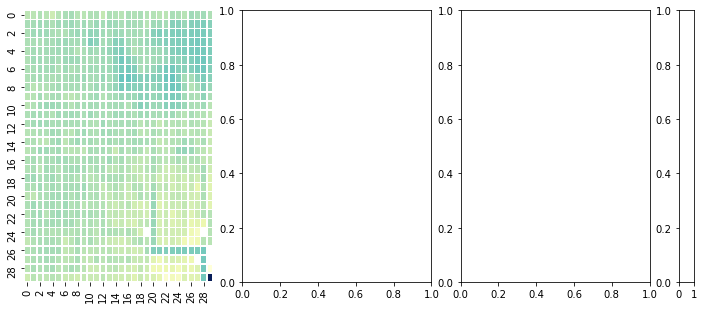

In [7]:
#!/usr/bin/env python3

import math

import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

# fig, ax = plt.subplots(figsize=(5,5)) 
f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, figsize=(12,5),
            gridspec_kw={'width_ratios':[1,1,1,0.08]})
ax1.get_shared_y_axes().join(ax2,ax3)


nrows = 30
ncols = 30
Cellid = [i for i in range(0,900)]
Cellval = visitCount[0]

data = np.zeros(nrows*ncols)
data[Cellid] = Cellval
data = np.ma.array(data.reshape((nrows, ncols)), mask=data==0)

log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

g1 = sns.heatmap(
    data,
    cmap = 'YlGnBu', #crest
    norm=log_norm,
    linewidths=.5,
    ax=ax1,
    cbar = False
#     cbar_kws={"ticks": cbar_ticks,'orientation': 'vertical','label': 'number of visits'}
)
g1.set_ylabel('')
g1.set_xlabel('')

# # passing a list is fine, no need to convert to tuples
# ax.set_xticklabels([i for i in range(1,11)])
# ax.set_yticklabels([i for i in range(1,11)])
# ax.set_xlabel('width')
# ax.set_ylabel('height')



Cellid = [i for i in range(0,100)]
Cellval = visitCount[1]

data = np.zeros(nrows*ncols)
data[Cellid] = Cellval
data = np.ma.array(data.reshape((nrows, ncols)), mask=data==0)

log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

g2 = sns.heatmap(
    data,
    cmap = 'YlGnBu', #crest
    norm=log_norm,
    linewidths=.5,
    ax=ax2,
    cbar = False
#     cbar_kws={"ticks": cbar_ticks,'orientation': 'vertical','label': 'number of visits'}
)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])



Cellid = [i for i in range(0,100)]
Cellval = visitCount[2]

data = np.zeros(nrows*ncols)
data[Cellid] = Cellval
data = np.ma.array(data.reshape((nrows, ncols)), mask=data==0)

log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

g3 = sns.heatmap(
    data,
    cmap = 'YlGnBu', #crest
    norm=log_norm,
    linewidths=.5,
    ax=ax3,
    cbar_ax=axcb,
    cbar_kws={"ticks": cbar_ticks,'orientation': 'vertical','label': 'Number of visits'}
)
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_yticks([])

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
#     ax.set_xticklabels([i for i in range(1,11)], rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
#     ax.set_yticklabels([p for p in range(0,10)], rotation=0)
    ax.set_xlabel("Width")
    ax.xaxis.tick_top()
g1.set_title("Agent-1")
g2.set_title("Agent-2")
g3.set_title("Agent-3")

g1.set_ylabel("Height")    
# plt.savefig('./stateVisitNumber.pdf',bbox_inches='tight') 
plt.show()
